In [1]:
import pint
si = pint.UnitRegistry()

from scipy.stats import lognorm
import numpy as np

from PyCloudParcel.parcel import parcel
from PyCloudParcel.phys import phys

%matplotlib inline
import matplotlib.pyplot as plt
si.setup_matplotlib()

ph = phys(si)

In [2]:
T0 = 280 * si.kelvin
p0 = 1000 * si.hectopascals
RH0 = .90

q0 = ph.eps/(p0 /RH0 /ph.pvs(T0) -1)

rm = 50 * si.nanometre
sg = 1.45
N = 100 / si.centimetre**3 #TODO

rho = p0 / ph.R(q0) / T0

rd = np.exp(np.linspace(
    np.log(5), # TODO: was 1nm in the paper...
    np.log(10000),
    20
)) * si.nanometre
nd = lognorm.pdf(rd.magnitude, np.log(sg), 0, rm.magnitude)
nd *= N / rho / np.sum(nd)  

w = lambda t: (2 + .05 * np.sin(t/.5/si.seconds)) * si.metre / si.second 

kp = .5

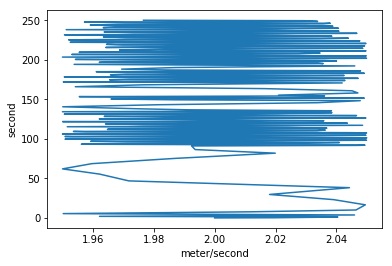

In [3]:
integ = {}
sys = {}

for label, micro in {"MM":('r',), "Fick/Fourier":('r','T')}.items():
    print(label, micro)

    integ[label], sys[label] = parcel(
        si = si,
        t = 250 * si.seconds,
        T0 = T0,
        q0 = q0,
        p0 = p0,
        w = w, 
        nd = nd, 
        rd = rd, 
        kp = kp,
        rtol=1e-4,
        thermo = ('S','p'),
        micro = micro
    )


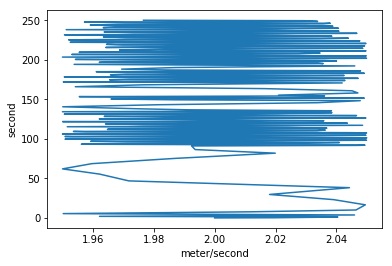

In [4]:
t = integ["MM"].t * sys["MM"].ix.t_unit
plt.plot(w(t), t)

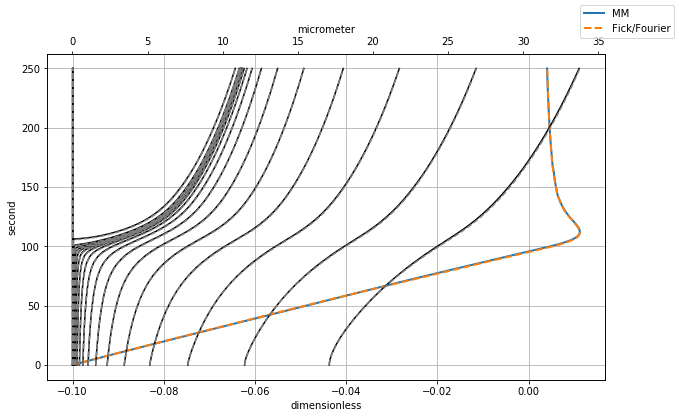

In [5]:
linestyles = {"MM":'-', "Fick/Fourier":'--'}
colors = {"MM":'black', "Fick/Fourier":'gray'}
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twiny()

for label, data in integ.items():
    ix = sys[label].ix
    fn = sys[label].fn
    ph = sys[label].ph
    
    p = data.y[ix.p] * ix.p_unit
    r = fn.r(data.y[ix.x] * ix.x_unit)
    t = data.t * ix.t_unit
    q = ph.q(sys[label].q1, nd, r)
    
    if hasattr(ix, 'S'):
        S = data.y[ix.S] * ix.S_unit
        T = ph.T(S,p,q)
    elif hasattr(ix, 'T'):
        T = data.y[ix.T] * ix.T_unit
        S = -1 + ph.RH(T, p, q) 
    else:
        assert False
    
    ax1.plot(S,t,label=label,linestyle=linestyles[label], linewidth=2)
    for i in range(len(r)):
        ax2.plot(r[i],t, linestyle=linestyles[label],color=colors[label])
fig.legend()
ax1.grid()
ax2.xaxis.set_units(si.micrometre)